In [1]:
using BSON: @load
using Flux
using Flux: chunk
using Flux.Data: DataLoader
using ImageFiltering
using Images
using ImageIO
using MLDatasets: FashionMNIST
using LinearAlgebra
using MLDatasets
using Plots
using Statistics
using JLD
using Distributions
using FFTW

Consider the denoising problem of recovering $x\in\mathbb{R}^n$ from noisy measurements of the form

$$y = x + \epsilon, $$

where $\epsilon\in\mathbb{R}^n$ is noise. We assume the unknown signal $x$ lives in the range of known generative model $G:\mathbb{R}^k \rightarrow \mathbb{R}^n$, i.e. $x = G(z)$ for some $z \in \mathbb{R}^k$. We assume the generative model $G$ is  fully-connected feedforward network of the form 

$$ G(x) = \sigma_d(A_d\sigma_{d-1}(A_{d-1} \cdots \sigma_1(A_1 z)\cdots)),$$

where $A_i \in \mathbb{R}^{n_i \times n_{i-1}}$ is the weight matrix and $\sigma_i$ is the activation function correpsonding to the $i\text{th}$ layer of $G$. Thus, the task of recovering $x$ can be reduced to recovering the corresponding $z$ such that $G(z) = x$. 


We solve this problem using the following iterative algorithm called Partially Linearized Updates for Generative Inversion (PLUGIn):

$$x^{k+1} = x^k -\eta A_1^{\top}\cdots A_d^{\top}\left(G(x^k) - y \right) .$$

Here, $\eta$ is the stepsize that depends on the weight matrices and the activation functions. This algorithm is implemented below:


High ratio $n_0 = 20, n_1 = 200, n_2 = 750$.

low ratio $n_0 = 70, n_1 = 200, n_2 =750$


In [2]:
# output the plugin Iterate
function PLUGIN_denoise(G, W, y, z, stepsize)
    d = W'* (G(z) - y )
    return z - stepsize * d
end

# output the plugin Iterate
function PLUGIN_denoise_regularized(G, W, y, z, stepsize, λ)
    d = W'* (G(z) - y ) + 2*λ*z  
    return z - stepsize * d
    println("1")
end

# output the plugin Iterate
function PLUGIN_denoise_normalized(G, W, y, z, stepsize, scale)
    d = W'* (G(z) - y)
    return (z - stepsize * d) * scale / norm(z - stepsize * d,2)
end

# output the plugin Iterate
function proj(z, scale)
    if norm(z) > scale
        z = scale * z/norm(z)
    end
    return z
end


function relative_error(x_true, x_estimate)
    return norm(x_true - x_estimate)/norm(x_true)
end

relative_error (generic function with 1 method)

One advantage of PLUGIn algorithm in general is that it allows us to pre-multiply the weight matrices. The following function is used to compute $A_d\cdot A_{d-1}\cdots A_1$ given a generative model $G$. It also normalizes each weight matrix w.r.t. its top singular value.

In [3]:
function normalized_weight_product(G)
    (_, z_dim) = size(Flux.params(G[1])[1]);
    W = I(z_dim)
    for i in 1:Int[length(Flux.params(G))/2][1]
        _, s, _ = svd(Flux.params(G)[2*i-1])
        W = Flux.params(G)[2*i-1] * W /(s[1]^2)
    end
    return W
end  

normalized_weight_product (generic function with 1 method)

The following function can be used to create a general generative function with number of nodes in each layer specified. The entries of the weight matrices are initialized to be normalized random normal.

In [4]:
function create_network(net_param)
    n_0 = net_param[1]
    n_1 = net_param[2]
    L = Chain(Dense(n_0, n_1, relu; initW =(out,in) ->  randn(n_1, n_0)/sqrt(n_1)))

    for i in 2:length(net_param)-1
        n_0 = net_param[i]
        n_1 = net_param[i+1]
        L = Chain(L, Dense(n_0, n_1, relu; initW =(out,in) ->  randn(n_1, n_0)/sqrt(n_1)))
    end
    return L
end

create_network (generic function with 1 method)

In [6]:
net_param = [20, 520, 500, 750]
G = create_network(net_param)
W = normalized_weight_product(G)

depth = length(Flux.params(G))/2

(_, z_dim) = size(Flux.params(G)[1]);
(x_dim, _ ) = size(Flux.params(G)[Int(depth*2 - 1)])
W = normalized_weight_product(G)

max_iter = 2000
stepsize_PLUGIn = 2
stepsize_GD = .5
noise_level_list = 0:.1:1
trials = 10
z = randn(z_dim)
z = z/norm(z) #unit sphere
noise_level = 0
noise_temp = randn(x_dim)
y = G(z) + noise_level * noise_temp/norm(noise_temp)

z_est_PLUGIn = randn(z_dim)
for iter in 1:max_iter
    z_est_PLUGIn = PLUGIN_denoise(G, W, y, z_est_PLUGIn, stepsize_PLUGIn)
end

println(norm(z_est_PLUGIn - z))


0.000129838768655338


In [7]:
#########  SNR  #################
net_param = [20, 520, 500, 750]
G = create_network(net_param)
W = normalized_weight_product(G)
depth = length(Flux.params(G))/2

(_, z_dim) = size(Flux.params(G)[1]);
(x_dim, _ ) = size(Flux.params(G)[Int(depth*2 - 1)])
W = normalized_weight_product(G)

max_iter = 2000
stepsize_PLUGIn = 2
stepsize_GD = .5
noise_level_list = 0:.1:1
trials = 10

recov_error_matrix_PLUGIn = zeros(length(noise_level_list))
recon_error_matrix_PLUGIn = zeros(length(noise_level_list))

recov_error_matrix_GD = zeros(length(noise_level_list))
recon_error_matrix_GD = zeros(length(noise_level_list))

recov_error_matrix_PLUGIn_proj = zeros(length(noise_level_list))
recon_error_matrix_PLUGIn_proj = zeros(length(noise_level_list))

recov_error_matrix_GD_proj = zeros(length(noise_level_list))
recon_error_matrix_GD_proj = zeros(length(noise_level_list))

recov_error_matrix_PLUGIn_normalized = zeros(length(noise_level_list))
recon_error_matrix_PLUGIn_normalized = zeros(length(noise_level_list))

recov_error_matrix_GD_normalized = zeros(length(noise_level_list))
recon_error_matrix_GD_normalized = zeros(length(noise_level_list))


recov_error_matrix_PLUGIn_reg = zeros(length(noise_level_list))
recon_error_matrix_PLUGIn_reg = zeros(length(noise_level_list))

recov_error_matrix_GD_reg = zeros(length(noise_level_list))
recon_error_matrix_GD_reg = zeros(length(noise_level_list))

for trial in 1:trials

    recov_error_PLUGIn = []
    recon_error_PLUGIn = []

    recov_error_GD = []
    recon_error_GD = []

    recov_error_PLUGIn_proj = []
    recon_error_PLUGIn_proj = []

    recov_error_GD_proj = []
    recon_error_GD_proj = []

    recov_error_PLUGIn_normalized = []
    recon_error_PLUGIn_normalized = []

    recov_error_GD_normalized = []
    recon_error_GD_normalized = []

    recov_error_PLUGIn_reg = []
    recon_error_PLUGIn_reg = []

    recov_error_GD_reg = []
    recon_error_GD_reg = []

    z = randn(z_dim)
    z = z/norm(z) #unit sphere
    
    for noise_level in noise_level_list

        noise_temp = randn(x_dim)
        y = G(z) + noise_level * noise_temp/norm(noise_temp)

        descent(z) = gradient(z->norm(G(z) - y,2)^2, z)[1]   

        
        descent_regularized(z, λ) = gradient(z -> norm(G(z) - y,2)^2 + λ*norm(z,2)^2, z)[1]        


        z_est_PLUGIn = randn(z_dim)
        z_est_GD = randn(z_dim)

        z_est_PLUGIn_proj = randn(z_dim)
        z_est_GD_proj = randn(z_dim)

        z_est_PLUGIn_normalized = randn(z_dim)
        z_est_GD_normalized = randn(z_dim)

        z_est_PLUGIn_reg = randn(z_dim)
        z_est_GD_reg = randn(z_dim)

        iter = 1
        for iter in 1:max_iter
            z_est_PLUGIn = PLUGIN_denoise(G, W, y, z_est_PLUGIn, stepsize_PLUGIn)
            d = descent(z_est_GD); z_est_GD -= stepsize_GD *d

            z_est_PLUGIn_proj = PLUGIN_denoise(G, W, y, z_est_PLUGIn_proj, stepsize_PLUGIn)
            z_est_PLUGIn_proj = proj(z_est_PLUGIn_proj, 1)
            d = descent(z_est_GD_proj); z_est_GD_proj -= stepsize_GD *d; z_est_GD_proj = proj(z_est_GD_proj, 1)


            z_est_PLUGIn_normalized = PLUGIN_denoise_normalized(G, W, y, z_est_PLUGIn_normalized, stepsize_PLUGIn, 1)
            d = descent(z_est_GD_normalized); z_est_GD_normalized -= stepsize_GD *d; z_est_GD_normalized = z_est_GD_normalized / norm(z_est_GD_normalized)

            z_est_PLUGIn_reg = PLUGIN_denoise_regularized(G, W, y, z_est_PLUGIn_reg, stepsize_PLUGIn, 0.01)
            d = descent_regularized(z_est_GD_reg, .01); z_est_GD_reg -= stepsize_GD *d

        end

        push!(recov_error_PLUGIn, relative_error(z, z_est_PLUGIn))
        push!(recon_error_PLUGIn,  relative_error(G(z), G(z_est_PLUGIn)) )

        push!(recov_error_GD, relative_error(z, z_est_GD))
        push!(recon_error_GD, relative_error(G(z), G(z_est_GD)) )  

        push!(recov_error_PLUGIn_proj, relative_error(z, z_est_PLUGIn_proj))
        push!(recon_error_PLUGIn_proj,  relative_error(G(z), G(z_est_PLUGIn_proj)) )

        push!(recov_error_GD_proj, relative_error(z, z_est_GD_proj))
        push!(recon_error_GD_proj, relative_error(G(z), G(z_est_GD_proj)) )  

        push!(recov_error_PLUGIn_normalized, relative_error(z, z_est_PLUGIn_normalized))
        push!(recon_error_PLUGIn_normalized,  relative_error(G(z), G(z_est_PLUGIn_normalized)) )

        push!(recov_error_GD_normalized, relative_error(z, z_est_GD_normalized))
        push!(recon_error_GD_normalized, relative_error(G(z), G(z_est_GD_normalized)) )  

        push!(recov_error_PLUGIn_reg, relative_error(z, z_est_PLUGIn_reg))
        push!(recon_error_PLUGIn_reg,  relative_error(G(z), G(z_est_PLUGIn_reg)) )

        push!(recov_error_GD_reg, relative_error(z, z_est_GD_reg))
        push!(recon_error_GD_reg, relative_error(G(z), G(z_est_GD_reg)) )  
    end

    recov_error_matrix_PLUGIn = hcat(recov_error_matrix_PLUGIn, recov_error_PLUGIn)
    recon_error_matrix_PLUGIn =  hcat(recon_error_matrix_PLUGIn, recon_error_PLUGIn)

    recov_error_matrix_GD = hcat(recov_error_matrix_GD, recov_error_GD)
    recon_error_matrix_GD = hcat(recon_error_matrix_GD, recon_error_GD)

    recov_error_matrix_PLUGIn_proj = hcat(recov_error_matrix_PLUGIn_proj, recov_error_PLUGIn_proj)
    recon_error_matrix_PLUGIn_proj =  hcat(recon_error_matrix_PLUGIn_proj, recon_error_PLUGIn_proj)

    recov_error_matrix_GD_proj = hcat(recov_error_matrix_GD_proj, recov_error_GD_proj)
    recon_error_matrix_GD_proj = hcat(recon_error_matrix_GD_proj, recon_error_GD_proj)

    recov_error_matrix_PLUGIn_normalized = hcat(recov_error_matrix_PLUGIn_normalized, recov_error_PLUGIn_normalized)
    recon_error_matrix_PLUGIn_normalized =  hcat(recon_error_matrix_PLUGIn_normalized, recon_error_PLUGIn_normalized)

    recov_error_matrix_GD_normalized = hcat(recov_error_matrix_GD_normalized, recov_error_GD_normalized)
    recon_error_matrix_GD_normalized = hcat(recon_error_matrix_GD_normalized, recon_error_GD_normalized)

    recov_error_matrix_PLUGIn_reg = hcat(recov_error_matrix_PLUGIn_reg, recov_error_PLUGIn_reg)
    recon_error_matrix_PLUGIn_reg =  hcat(recon_error_matrix_PLUGIn_reg, recon_error_PLUGIn_reg)

    recov_error_matrix_GD_reg = hcat(recov_error_matrix_GD_reg, recov_error_GD_reg)
    recon_error_matrix_GD_reg = hcat(recon_error_matrix_GD_reg, recon_error_GD_reg)

end

# save("result/talk/Denoise/denoise_recov_low_ratio.jld", "error_GD", recov_error_matrix_GD, "error_PLUGIn", recov_error_matrix_PLUGIn, "error_GD_proj", recov_error_matrix_GD_proj, "error_PLUGIn_proj", recov_error_matrix_PLUGIn_proj, "error_GD_reg", recov_error_matrix_GD_reg, "error_PLUGIn_reg", recov_error_matrix_PLUGIn_reg)


# save("result/talk/Denoise/denoise_recon_low_ratio.jld", "error_GD", recon_error_matrix_GD, "error_PLUGIn", recon_error_matrix_PLUGIn, "error_GD_proj", recon_error_matrix_GD_proj, "error_PLUGIn_proj", recon_error_matrix_PLUGIn_proj, "error_GD_reg", recon_error_matrix_GD_reg, "error_PLUGIn_reg", recon_error_matrix_PLUGIn_reg)

In [29]:
save("result/talk/Denoise/denoise_recov_high_ratio.jld", "error_GD", recov_error_matrix_GD, "error_PLUGIn", recov_error_matrix_PLUGIn, "error_GD_proj", recov_error_matrix_GD_proj, "error_PLUGIn_proj", recov_error_matrix_PLUGIn_proj, "error_GD_reg", recov_error_matrix_GD_reg, "error_PLUGIn_reg", recov_error_matrix_PLUGIn_reg)

save("result/talk/Denoise/denoise_recon_high_ratio.jld", "error_GD", recon_error_matrix_GD, "error_PLUGIn", recon_error_matrix_PLUGIn, "error_GD_proj", recon_error_matrix_GD_proj, "error_PLUGIn_proj", recon_error_matrix_PLUGIn_proj, "error_GD_reg", recon_error_matrix_GD_reg, "error_PLUGIn_reg", recon_error_matrix_PLUGIn_reg)


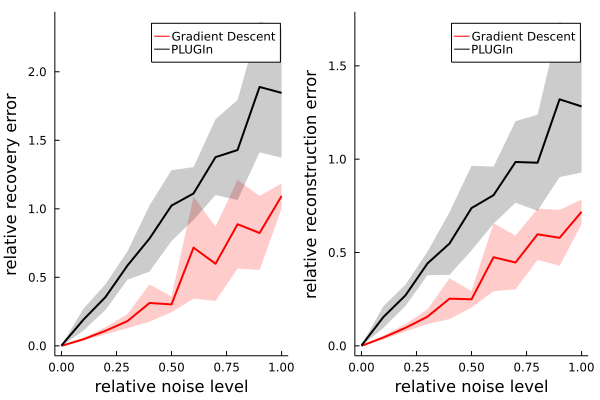

In [9]:
# recov_error_matrix_GD = load("result/talk/error_denoise_recov.jld",  "error_GD")
# recov_error_matrix_PLUGIn = load("result/talk/error_denoise_recov.jld",  "error_PLUGIn")
# recon_error_matrix_GD = load("result/talk/error_denoise_recon.jld",  "error_GD")
# recon_error_matrix_PLUGIn = load("result/talk/error_denoise_recon.jld",  "error_PLUGIn")


average_recov = mean(recov_error_matrix_GD[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_GD[:, 2:end], dims=2)
plot(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .2, color =:red, label = false, linecolor = invisible())
plot!(noise_level_list, average_recov, label = "Gradient Descent", xlabel = "relative noise level", ylabel = "average recovery error", linewidth = 2, color =:red)

average_recov = mean(recov_error_matrix_PLUGIn[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_PLUGIn[:, 2:end], dims=2)
plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .2, c =:black, label = false, linecolor = invisible())
p1 = plot!(noise_level_list, average_recov, label = "PLUGIn", xlabel = "relative noise level", ylabel = "relative recovery error", linewidth = 2, color =:black , grid= false)


#################################################################################
average_recon = mean(recon_error_matrix_GD[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_GD[:, 2:end], dims=2)
plot(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = .2, color =:red, label = false, linecolor = invisible())
plot!(noise_level_list, average_recon, label = "Gradient Descent", xlabel = "relative noise level", ylabel = "average reconstruction error", linewidth = 2, c =:red)


average_recon = mean(recon_error_matrix_PLUGIn[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_PLUGIn[:, 2:end], dims=2)
plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = .2, c =:black, label = false, linecolor = invisible())
p2 = plot!(noise_level_list, average_recon, label = "PLUGIn", xlabel = "relative noise level", ylabel = "relative reconstruction error", linewidth = 2 , c =:black, grid= false)


plot(p1, p2, layout = (1,2))


savefig("result/talk/Denoise_non_expans_high_ratio.pdf")
plot(p1, p2, layout = (1,2))


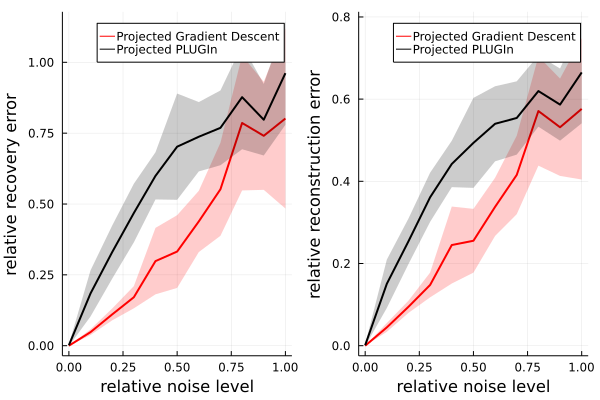

In [10]:


average_recov = mean(recov_error_matrix_GD_proj[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_GD_proj[:, 2:end], dims=2)
plot(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .2, color =:red, label = false, linecolor = invisible())
plot!(noise_level_list, average_recov, label = "Projected Gradient Descent", xlabel = "noise level", ylabel = "average recovery error", linewidth = 2, color =:red)

average_recov = mean(recov_error_matrix_PLUGIn_proj[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_PLUGIn_proj[:, 2:end], dims=2)
plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .2, c =:black, label = false, linecolor = invisible())
p1 = plot!(noise_level_list, average_recov, label = "Projected PLUGIn", xlabel = "relative noise level", ylabel = "relative recovery error", linewidth = 2, color =:black )


#################################################################################
average_recon = mean(recon_error_matrix_GD_proj[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_GD_proj[:, 2:end], dims=2)
plot(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = .2, color =:red, label = false, linecolor = invisible())
plot!(noise_level_list, average_recon, label = "Projected Gradient Descent", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 2, c =:red)


average_recon = mean(recon_error_matrix_PLUGIn_proj[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_PLUGIn_proj[:, 2:end], dims=2)
plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = .2, c =:black, label = false, linecolor = invisible())
p2 = plot!(noise_level_list, average_recon, label = "Projected PLUGIn", xlabel = "relative noise level", ylabel = "relative reconstruction error", linewidth = 2 , c =:black)

plot(p1, p2, layout = (1,2))
savefig("result/talk/Denoise_non_expanse_proj_high_ratio.pdf")
plot(p1, p2, layout = (1,2))


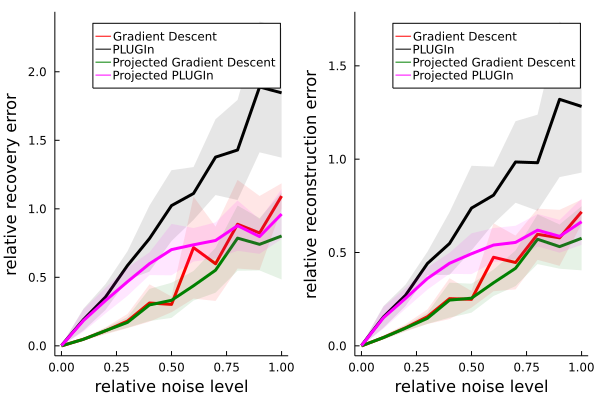

In [11]:



average_recov = mean(recov_error_matrix_GD[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_GD[:, 2:end], dims=2)
plot(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .1, color =:red, label = false, linecolor = invisible())
plot!(noise_level_list, average_recov, label = "Gradient Descent", xlabel = "relative noise level", ylabel = "average recovery error", linewidth = 3, color =:red)

average_recov = mean(recov_error_matrix_PLUGIn[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_PLUGIn[:, 2:end], dims=2)
plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .1, c =:black, label = false,linecolor = invisible())
plot!(noise_level_list, average_recov, label = "PLUGIn", xlabel = "relative noise level", ylabel = "relative recovery error", linewidth = 3, color =:black , grid= false)


average_recov = mean(recov_error_matrix_GD_proj[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_GD_proj[:, 2:end], dims=2)
plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .1, color =:green, label = false,linecolor = invisible())
plot!(noise_level_list, average_recov, label = "Projected Gradient Descent", xlabel = "noise level", ylabel = "average recovery error", linewidth = 3, color =:green)

average_recov = mean(recov_error_matrix_PLUGIn_proj[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_PLUGIn_proj[:, 2:end], dims=2)
plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .1, c =:magenta, label = false,linecolor = invisible())
p1 = plot!(noise_level_list, average_recov, label = "Projected PLUGIn", xlabel = "relative noise level", ylabel = "relative recovery error", linewidth = 3, color =:magenta )



################################################################################
average_recon = mean(recon_error_matrix_GD[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_GD[:, 2:end], dims=2)
plot(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = .1, color =:red, label = false,linecolor = invisible())
plot!(noise_level_list, average_recon, label = "Gradient Descent", xlabel = "relative noise level", ylabel = "average reconstruction error", linewidth = 3, c =:red)


average_recon = mean(recon_error_matrix_PLUGIn[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_PLUGIn[:, 2:end], dims=2)
plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = .1, c =:black, label = false, linecolor = invisible())
plot!(noise_level_list, average_recon, label = "PLUGIn", xlabel = "relative noise level", ylabel = "relative reconstruction error", linewidth = 3 , c =:black, grid= false)


average_recon = mean(recon_error_matrix_GD_proj[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_GD_proj[:, 2:end], dims=2)
plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = .1, color =:green, label = false,linecolor = invisible())
plot!(noise_level_list, average_recon, label = "Projected Gradient Descent", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 3, c =:green)


average_recon = mean(recon_error_matrix_PLUGIn_proj[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_PLUGIn_proj[:, 2:end], dims=2)
plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = .1, c =:magenta, label = false,linecolor = invisible())
p2 = plot!(noise_level_list, average_recon, label = "Projected PLUGIn", xlabel = "relative noise level", ylabel = "relative reconstruction error", linewidth = 3 , c =:magenta)


p = plot(p1,p2, layout=(1,2))
savefig(p, "result/talk/Denoise_non_expanse_comparison_high_ratio.pdf")
plot(p1,p2, layout=(1,2))


In [22]:
noise_level_list

0.0:0.05:0.5

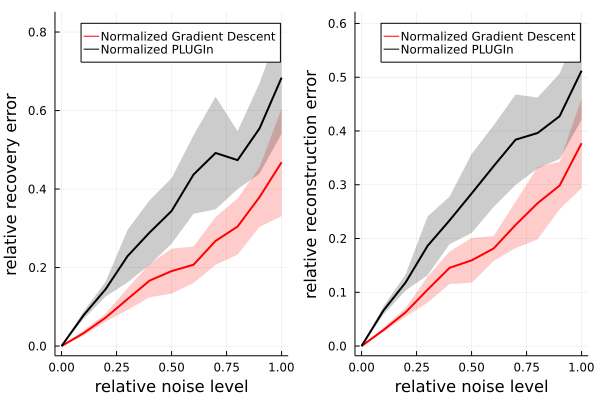

In [33]:
average_recov = mean(recov_error_matrix_GD_normalized[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_GD_normalized[:, 2:end], dims=2)
plot(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .2, color =:red, label = false, linecolor = invisible())
plot!(noise_level_list, average_recov, label = "Normalized Gradient Descent", xlabel = "noise level", ylabel = "average recovery error", linewidth = 2, color =:red)

average_recov = mean(recov_error_matrix_PLUGIn_normalized[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_PLUGIn_normalized[:, 2:end], dims=2)
plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .2, c =:black, label = false, linecolor = invisible())
p1 = plot!(noise_level_list, average_recov, label = "Normalized PLUGIn", xlabel = "relative noise level", ylabel = "relative recovery error", linewidth = 2, color =:black )


#################################################################################
average_recon = mean(recon_error_matrix_GD_normalized[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_GD_normalized[:, 2:end], dims=2)
plot(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = .2, color =:red, label = false, linecolor = invisible())
plot!(noise_level_list, average_recon, label = "Normalized Gradient Descent", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 2, c =:red)


average_recon = mean(recon_error_matrix_PLUGIn_normalized[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_PLUGIn_normalized[:, 2:end], dims=2)
plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = .2, c =:black, label = false, linecolor = invisible())
p2 = plot!(noise_level_list, average_recon, label = "Normalized PLUGIn", xlabel = "relative noise level", ylabel = "relative reconstruction error", linewidth = 2 , c =:black)

plot(p1, p2, layout = (1,2))
savefig("result/talk/Denoise/Denoise_normalized_high_ratio.pdf")
plot(p1, p2, layout = (1,2))


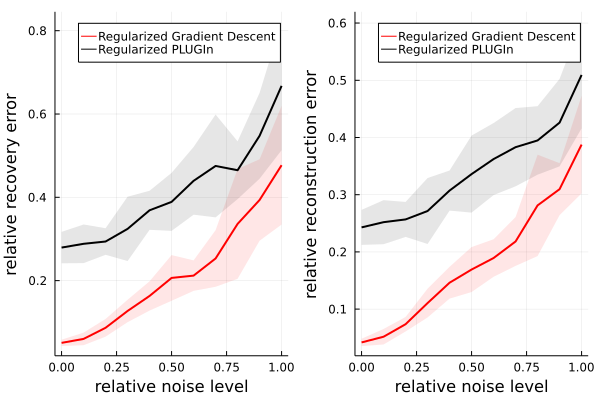

In [34]:

average_recov = mean(recov_error_matrix_GD_reg[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_GD_reg[:, 2:end], dims=2)
plot(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .1, color =:red, label = false, linecolor = invisible())
plot!(noise_level_list, average_recov, label = "Regularized Gradient Descent", xlabel = "noise level", ylabel = "average recovery error", linewidth = 2, color =:red)

average_recov = mean(recov_error_matrix_PLUGIn_reg[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_PLUGIn_reg[:, 2:end], dims=2)
plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .1, c =:black, label = false, linecolor = invisible())
p1 = plot!(noise_level_list, average_recov, label = "Regularized PLUGIn", xlabel = "relative noise level", ylabel = "relative recovery error", linewidth = 2, color =:black )


#################################################################################
average_recon = mean(recon_error_matrix_GD_reg[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_GD_reg[:, 2:end], dims=2)
plot(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = .1, color =:red, label = false, linecolor = invisible())
plot!(noise_level_list, average_recon, label = "Regularized Gradient Descent", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 2, c =:red)


average_recon = mean(recon_error_matrix_PLUGIn_reg[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_PLUGIn_reg[:, 2:end], dims=2)
plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = .1, c =:black, label = false, linecolor = invisible())
p2 = plot!(noise_level_list, average_recon, label = "Regularized PLUGIn", xlabel = "relative noise level", ylabel = "relative reconstruction error", linewidth = 2 , c =:black)


plot(p1, p2, layout = (1,2))
savefig("result/talk/Denoise/Denoise_reg_high_ratio.pdf")
plot(p1, p2, layout = (1,2))


In [22]:
cs = palette([:red,  :orange, :green, :blue, :Indigo, :violet], 1000)

In [147]:
########## OVERFIT ###############

net_param = [40, 200, 750]
G = create_network(net_param)
W = normalized_weight_product(G)

depth = length(Flux.params(G))/2

(_, z_dim) = size(Flux.params(G)[1]);
(x_dim, _ ) = size(Flux.params(G)[Int(depth*2 - 1)])
stepsize = 1.5
max_iter = 100
noise_level = 1
# tolerance = 1e-4
W = normalized_weight_product(G)
trials = 100

recov_error_matrix = zeros(max_iter, 1)
recon_error_matrix = zeros(max_iter, 1)

for trial in 1:trials
    recov_error = []
    recon_error = []
    z = randn(z_dim)
    z = z / norm(z)

    noise = randn(x_dim)
    noise =  noise_level * noise / norm(noise) 
    y = G(z) + noise
    z_est = zeros(z_dim)
    iter = 1
    succ_error = 1

    for iter in 1:max_iter
        z_old = z_est
        z_est = PLUGIN_denoise(G, W, y, z_est, stepsize)
        succ_error = norm(z_old - z_est, 2)

        push!( recon_error, norm(G(z) - G(z_est))/norm(G(z)) )
        push!( recov_error, norm(z - z_est)/norm(z_est) )

    end
    recov_error_matrix = hcat(recov_error_matrix, recov_error)
    recon_error_matrix = hcat(recon_error_matrix, recon_error)
end

# change the filenames if you wish to save the results
save("result/talk/Denoise/overfit.jld", "error_recov", recov_error_matrix[:,2:end],  "error_recon", recon_error_matrix[:,2:end], "iterations", 1:max_iter)

average_recov = mean(recov_error_matrix[:,2:end], dims=2)
std_recov = std(recov_error_matrix[:,2:end], dims=2)
plot(1:max_iter, average_recov + std_recov, fillrange = average_recov - std_recov,fillalpha = 0.35, c = 1, label = false)
p1 = plot!(1:max_iter, average_recov, label = "recovery error")

average_recon = mean(recon_error_matrix[:,2:end], dims=2)
std_recon = std(recon_error_matrix[:,2:end], dims=2)
plot(1:max_iter, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = 0.35, c = 1, label = false)
p2 = plot!(1:max_iter, average_recon, label = "reconstruction error")
plot(p1, p2, layout = (1,2), xlabel = "iteration number", ylabel = "relative error")


savefig("result/talk/Denoise/overfit.pdf")
